In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.optimize as optimize
from sklearn.metrics import mean_absolute_error
import time

# Gradient Boosting
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import seaborn
from scipy.stats import norm

#ARIMA 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# UCM
import statsmodels.api as sm
from IPython.display import display, Latex

# integration
from scipy.integrate import simps
from numpy import trapz

In [39]:
def Production_models(df, time_future, time_length, title):
    '''dataframe needs to have columns "Production" and "month" to work properly.
    Time future is the time in months that need to be added. 
    time start is the time starting before the end of the production period. 
    ex: time_start = 0 is a future predction
    Added code to pass arps when not converging
    '''
    
    #This is the time that the model begins    
#    time_length = len(df['month'].values) - time_start
    
    ##ARPs
    ## --- need to change well 7 potentially

    arps = df[['Production', 'month']]

    arps.head()

    def Exponential(t, di):
        qi = arps['Production'].max()
        return qi*np.exp(-di*t)

    def Hyperbolic(t, b, di):
        qi = arps['Production'].max()
        return qi/((1.0+b*di*t)**(1/b))

    def Harmonic(t, qi, di):
        return qi/(1+di*t)


    arps = df[['Production', 'month']]
    arps.head()


    qi = arps['Production'].max()
    x_arps = arps['month'].values
    y_arps = arps['Production'].values

    try:
        #Optimizing Curves
        popt, pcov = curve_fit(Exponential, x_arps, y_arps)
        exp_vars = popt
        popt, pcov = curve_fit(Hyperbolic, x_arps, y_arps)
        unconstrained_vars = popt
        popt, pcov = curve_fit(Hyperbolic, x_arps, y_arps, bounds= ([0,0], [1,5]))
        constrained_vars = popt

        #analyzing error
        MAE_exp = mean_absolute_error(y_arps, Exponential(x_arps, *exp_vars))
        MAE_Hyper = mean_absolute_error(y_arps, Hyperbolic(x_arps, *unconstrained_vars))
        MAE_Hyper_constrained = mean_absolute_error(y_arps, Hyperbolic(x_arps, *constrained_vars))

        Errors = {
            "Exponential" : MAE_exp,
            "Hyperbolic_u" : MAE_Hyper,
            "Hyperbolic_c" : MAE_Hyper_constrained
        }


        ## best fit + 120 months in the future
        x_arps_future = range(0, time_length+time_future)
        production_arps = Hyperbolic(x_arps_future, *unconstrained_vars)
    except:
        pass



    ########GB
    GB_df = df[['Production', 'month']]
    y_GB = GB_df['Production'].values
    y_GB = y_GB[0: time_length]

    x_GB = GB_df['month'].values
    x_GB = x_GB[0: time_length]
    X_GB = x_GB.reshape(-1,1)
    X_GB = x_GB[:, np.newaxis]
    x_plot_GB = np.linspace(0, time_length+time_future, time_length+time_future)
    X_plot_GB = x_plot_GB[:, np.newaxis]
    lw = 2
    degree = 1

    model_GB = Pipeline(steps=[('poly', PolynomialFeatures(degree)),
                    ('ridge', Ridge(fit_intercept=True))])
    model_GB.fit(X_GB, y_GB)
    y_plot_GB = model_GB.predict(X_plot_GB)

    alpha = 0.95
    ##Haven't tuned any parameters yet
    GBR = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                    n_estimators=100, max_depth=5,
                                    learning_rate=.1, min_samples_leaf=5,
                                    min_samples_split=3)
    GBR.fit(X_GB,y_GB)
    y_upper = GBR.predict(X_plot_GB)

    GBR.set_params(alpha=1.0 - alpha)
    GBR.fit(X_GB, y_GB)
    y_lower = GBR.predict(X_plot_GB)


    GBR.set_params(loss='ls')
    GBR.fit(X_GB,y_GB)
    y_pred_GB = GBR.predict(X_plot_GB)

    ## X_plot_GB, y_pred_GB

    ## ARIMA Model
    ARIMA_df = df[['Production', 'month']]

    X_AR = ARIMA_df['Production'].values[0: time_length]
    X_AR = X_AR.reshape(-1,1)
    X_AR = X_AR.astype('float32')
    size = len(X_AR) - 1
    train_AR, test_AR = X_AR[0:size], X_AR[size:]

    ## order(p,d,q) - p = order of AR, d = order of I, and q = order of MA
    ## need to tune these--
    model_AR = ARIMA(train_AR, order = (1,1,1))
    model_fit_AR = model_AR.fit(disp=False)

    ## set confidence interval to whatever
    confidence_interval = 95
    a = (100 - confidence_interval)/100

    forecast_AR, stderr, conf = model_fit_AR.forecast(alpha = a)

    plot_end_value = len(train_AR) + time_future
    plot_start_value = len(train_AR)-size+1

    confidence_interval = 50
    a = (100 - confidence_interval)/100
    ### Could plot until it reaches an intercept of zero then integrate

    prediction_AR = model_fit_AR.forecast(steps=time_future)
    #print(ARIMA_forecats)

    ## end values
    ## ARIMA_forecats
    #print(prediction_AR[0])
    X_AR_pred = range(time_length,time_length+time_future)
    #len(prediction_AR[0])

    ## UCM - Unobserved component model

    oildata = df[['Production', 'month']]
    #index = df['month']
    #oildata = pd.Series(data_well7, index)
    # Model specifications
    # Unrestricted model, using string specification
    unrestricted_model = {
        'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    }

    # Unrestricted model, setting components directly
    # This is an equivalent, but less convenient, way to specify a
    # local linear trend model with a stochastic damped cycle:
    # unrestricted_model = {
    #     'irregular': True, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True,
    #     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    # }

    # The restricted model forces a smooth trend
    restricted_model = {
        'level': 'smooth trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    }

    # Restricted model, setting components directly
    # This is an equivalent, but less convenient, way to specify a
    # smooth trend model with a stochastic damped cycle. Notice
    # that the difference from the local linear trend model is that
    # `stochastic_level=False` here.
    # unrestricted_model = {
    #     'irregular': True, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True,
    #     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    # }


    # well production
    prod_mod = sm.tsa.UnobservedComponents(oildata['Production'], **unrestricted_model)
    prod_res = prod_mod.fit(method='powell', disp=False)

    prod_restricted_mod = sm.tsa.UnobservedComponents(oildata['Production'], **restricted_model)
    prod_restricted_res = prod_restricted_mod.fit(method='powell', disp=False)
    predict_ucm = prod_res.forecast(steps=time_future)
    ucm_pred = predict_ucm.values

    predict_ucm_res = prod_restricted_res.forecast(steps=time_future)
    ucm_pred_res = predict_ucm_res.values

    y_GB_future = y_pred_GB[time_length:time_length+time_future]
    try:
        production_arps_future = production_arps[time_length:time_length+time_future]
    except:
        pass
    AR_future =  prediction_AR[0]

    ensemble_df = []
    try:
        for i in range(0,time_future):
            average = (y_GB_future[i] + production_arps_future[i] + AR_future[i] + ucm_pred[i])/4
            ensemble_df.append(average)
    except:
        for i in range(0,time_future):
            average = (y_GB_future[i] + AR_future[i] + ucm_pred[i])/4
            ensemble_df.append(average)        

    #Some Combined Plots:
#    fig = plt.figure(figsize = (12,12))

    ARIMA_pred = prediction_AR[0]
    plt.plot(x_arps, y_arps, marker='', color='black', linewidth=1, label = "Well Production")
    try:
        plt.plot(x_arps_future, production_arps, 'r-', label = 'ARPs')
    except:
        pass
    plt.plot(X_plot_GB, y_pred_GB, '#0068b0', label=u'Gradient Boosting')
    plt.plot(X_AR_pred, ARIMA_pred, marker = '', color = 'blue', label = 'ARIMAX', linewidth=1)
    plt.plot(X_AR_pred, ucm_pred, marker = '', color='yellowgreen', label = 'UCM - unrestricted', linewidth=1)
    plt.plot(X_AR_pred, ensemble_df, marker = '', color='skyblue', label = 'Ensemble Model', linewidth=1)
    
    plt.title(str(title))
    plt.xlabel('months')
    plt.ylabel('bbl')
    plt.legend()
    plt.show()
    plt.savefig(r'E:\California data\csvs\graphs\forecast'+str(title)+'.png',
                format = "PNG", bbox_inches = 'tight')
    
    def compute_area(y, init, final):
        for i in range(init, final):
            if y[i] < 0:
                y[i] = 0
            else:
                y[i] = y[i]
        min_y = np.argmin(y)
        y  = y[init:min_y]
        x = min_y - init
        area_t = trapz(y, dx=x)
        area_s = simps(y, dx=x)
        area = (area_t + area_s)/2
        return area_t

    def compute_area_GB(y, init, final):
        for i in range(init, final):
            if y[i] < 0:
                y[i] = 0
            else:
                y[i] = y[i]

        y  = y[init:final]
        x = final - init
        area_t = trapz(y, dx=x)
        area_s = simps(y, dx=x)
        area = (area_t + area_s)/2
        return area_t
    
    Data_length = time_length
    predict_length = Data_length + time_future
    try:
        ARPs_pred_corr = compute_area(production_arps, Data_length, predict_length)
    except:
        pass

    GB_pred_corr = compute_area_GB(y_pred_GB, Data_length, predict_length)

    ARIMA_pred_corr = compute_area(ARIMA_pred, 0, time_future)

    UCM_pred_corr = compute_area(ucm_pred, 0, time_future)

    Ensemble_pred_corr = compute_area(ensemble_df, 0, time_future)
    try:
        EUR = round((ARPs_pred_corr + GB_pred_corr + ARIMA_pred_corr + 
                             UCM_pred_corr + Ensemble_pred_corr) / 5, 1)
    except:
        EUR = round((GB_pred_corr + ARIMA_pred_corr + 
                     UCM_pred_corr + Ensemble_pred_corr) /4, 1)
  
    
    # would only work when not predicting in the future
    try:
        actual_EUR = compute_area_GB(y_arps, Data_length, predict_length)
    except:
        pass

    try:
        return ARPs_pred_corr, GB_pred_corr, ARIMA_pred_corr, UCM_pred_corr, Ensemble_pred_corr, EUR, actual_EUR
    except:
        return GB_pred_corr, ARIMA_pred_corr, UCM_pred_corr, Ensemble_pred_corr, EUR
        



In [40]:
df = pd.read_csv(r'C:\Users\Preston\Desktop\data from Z\Reynolds data from z.csv')

## Well Select
df = df[df['Metering Point'].isin(['REYNOLDS GAS UNIT 1 5H'])]

df['Date'] = pd.to_datetime(df.PERIOD)
df = df.sort_values(by=['Date'])
df = df.reset_index()
df['Production'] = df['MCF']

df['detla_date'] = abs(df['Date'] - df['Date'].loc[0] )
df['cumm_date'] =  df['detla_date'] / np.timedelta64(1,'D')
#df['month'] = df['cumm_date']
df['month'] = df.index

df = df[['Production', 'month']]

df.head(15)

,Production,month
0,0.000000,0
1,18972.860000,1
2,36894.290000,2
3,11545.585910,3
4,11707.000000,4
5,9823.163361,5
6,9654.058533,6
7,8661.607727,7
8,9794.089752,8
9,10260.892060,9


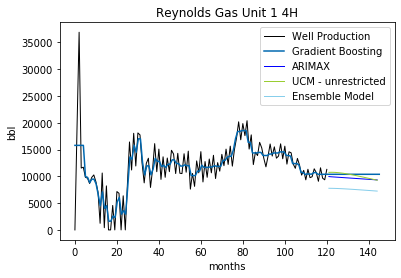

(5730707.787843483, 4884717.844523703, 5169966.605139008, 3826958.3137964765, 4903087.6)


<Figure size 432x288 with 0 Axes>

In [41]:
time_future = 24
time_length = len(df['month'].values)
columns = ['GB', 'ARIMA', 'UCM', 'Ensemble', 'EUR']
results = Production_models(df, time_future, time_length, 'Reynolds Gas Unit 1 5H')
print(results)
#results_df = pd.DataFrame([np.transpose(results)], columns = columns)
#results_df['id'] = str(i)
#eur = pd.concat([eur, results_df])  




In [147]:
df = pd.read_csv(r'C:\Users\Preston\Desktop\data from Z\Reynolds data from z.csv')

## Well Select
df = df[df['Metering Point'].isin(['REYNOLDS CDP'])]

df['Date'] = pd.to_datetime(df.PERIOD)
df = df.sort_values(by=['Date'])
df = df.reset_index()
df['Production'] = df['MCF']

df['detla_date'] = abs(df['Date'] - df['Date'].loc[0] )
df['cumm_date'] =  df['detla_date'] / np.timedelta64(1,'D')

#df['month'] = df['cumm_date']
df['month'] = df.index

df = df[['Production', 'month']]
df = df.drop_duplicates(subset = "month", keep = "last")
df['month'] = df['month'].apply(np.int64)
df = df.reset_index()
df.tail(15)


,index,Production,month
177,177,233.21,177
178,178,10064.45,178
179,179,203.22,179
180,180,243.35,180
181,181,9961.64,181
182,182,115.88,182
183,183,9229.33,183
184,184,151.71,184
185,185,261.30,185
186,186,155.07,186


In [148]:
def Production_models(df, time_future, title):
    '''dataframe needs to have columns "Production" and "month" to work properly.
    Time future is the time in months that need to be added. 
    time start is the time starting before the end of the production period. 
    ex: time_start = 0 is a future predction
    Added code to pass arps when not converging
    '''
    
    #This is the time that the model begins    
#    time_length = len(df['month'].values) - time_start
    
    ##ARPs
    ## --- need to change well 7 potentially
    
    
    index_len = len(df.index)
    time_length = max(df['month'].values)

    
    arps = df[['Production', 'month']]

    arps.head()

    def Exponential(t, di):
        qi = arps['Production'].max()
        return qi*np.exp(-di*t)

    def Hyperbolic(t, b, di):
        qi = arps['Production'].max()
        return qi/((1.0+b*di*t)**(1/b))

    def Harmonic(t, qi, di):
        return qi/(1+di*t)


    arps = df[['Production', 'month']]
    arps.head()


    qi = arps['Production'].max()
    x_arps = arps['month'].values
    y_arps = arps['Production'].values

    try:
        #Optimizing Curves
        popt, pcov = curve_fit(Exponential, x_arps, y_arps)
        exp_vars = popt
        popt, pcov = curve_fit(Hyperbolic, x_arps, y_arps)
        unconstrained_vars = popt
        popt, pcov = curve_fit(Hyperbolic, x_arps, y_arps, bounds= ([0,0], [1,5]))
        constrained_vars = popt

        #analyzing error
        MAE_exp = mean_absolute_error(y_arps, Exponential(x_arps, *exp_vars))
        MAE_Hyper = mean_absolute_error(y_arps, Hyperbolic(x_arps, *unconstrained_vars))
        MAE_Hyper_constrained = mean_absolute_error(y_arps, Hyperbolic(x_arps, *constrained_vars))

        Errors = {
            "Exponential" : MAE_exp,
            "Hyperbolic_u" : MAE_Hyper,
            "Hyperbolic_c" : MAE_Hyper_constrained
        }


        ## best fit + 120 months in the future
        x_arps_future = range(0, time_length+time_future)
        production_arps = Hyperbolic(x_arps_future, *unconstrained_vars)
    except:
        pass



    ########GB
    GB_df = df[['Production', 'month']]
    y_GB = GB_df['Production'].values
    y_GB = y_GB[0: index_len]

    x_GB = GB_df['month'].values
    x_GB = x_GB[0: index_len]
    X_GB = x_GB.reshape(-1,1)
    X_GB = x_GB[:, np.newaxis]
    x_plot_GB = np.linspace(0, time_length+time_future, time_length+time_future)
    X_plot_GB = x_plot_GB[:, np.newaxis]
    lw = 2
    degree = 1

    model_GB = Pipeline(steps=[('poly', PolynomialFeatures(degree)),
                    ('ridge', Ridge(fit_intercept=True))])
    model_GB.fit(X_GB, y_GB)
    y_plot_GB = model_GB.predict(X_plot_GB)

    alpha = 0.95
    ##Haven't tuned any parameters yet
    GBR = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                    n_estimators=100, max_depth=5,
                                    learning_rate=.1, min_samples_leaf=5,
                                    min_samples_split=3)
    GBR.fit(X_GB,y_GB)
    y_upper = GBR.predict(X_plot_GB)

    GBR.set_params(alpha=1.0 - alpha)
    GBR.fit(X_GB, y_GB)
    y_lower = GBR.predict(X_plot_GB)


    GBR.set_params(loss='ls')
    GBR.fit(X_GB,y_GB)
    y_pred_GB = GBR.predict(X_plot_GB)

    ## X_plot_GB, y_pred_GB

    ## ARIMA Model
    ARIMA_df = df[['Production', 'month']]

    X_AR = ARIMA_df['Production'].values[0:  index_len]
    X_AR = X_AR.reshape(-1,1)
    X_AR = X_AR.astype('float32')
    size = len(X_AR) - 1
    train_AR, test_AR = X_AR[0:size], X_AR[size:]

    ## order(p,d,q) - p = order of AR, d = order of I, and q = order of MA
    ## need to tune these--
    model_AR = ARIMA(train_AR, order = (1,1,1))
    model_fit_AR = model_AR.fit(disp=False)

    ## set confidence interval to whatever
    confidence_interval = 95
    a = (100 - confidence_interval)/100

    forecast_AR, stderr, conf = model_fit_AR.forecast(alpha = a)

    plot_end_value = len(train_AR) + time_future
    plot_start_value = len(train_AR)-size+1

    confidence_interval = 50
    a = (100 - confidence_interval)/100
    ### Could plot until it reaches an intercept of zero then integrate

    prediction_AR = model_fit_AR.forecast(steps = time_future)
    #print(ARIMA_forecats)

    ## end values
    ## ARIMA_forecats
    #print(prediction_AR[0])
    X_AR_pred = range(time_length, time_length+time_future)
    #len(prediction_AR[0])

    ## UCM - Unobserved component model

    oildata = df[['Production', 'month']]
    #index = df['month']
    #oildata = pd.Series(data_well7, index)
    # Model specifications
    # Unrestricted model, using string specification
    unrestricted_model = {
        'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    }

    # Unrestricted model, setting components directly
    # This is an equivalent, but less convenient, way to specify a
    # local linear trend model with a stochastic damped cycle:
    # unrestricted_model = {
    #     'irregular': True, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True,
    #     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    # }

    # The restricted model forces a smooth trend
    restricted_model = {
        'level': 'smooth trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    }

    # Restricted model, setting components directly
    # This is an equivalent, but less convenient, way to specify a
    # smooth trend model with a stochastic damped cycle. Notice
    # that the difference from the local linear trend model is that
    # `stochastic_level=False` here.
    # unrestricted_model = {
    #     'irregular': True, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True,
    #     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    # }


    # well production
    prod_mod = sm.tsa.UnobservedComponents(oildata['Production'], **unrestricted_model)
    prod_res = prod_mod.fit(method='powell', disp=False)

    prod_restricted_mod = sm.tsa.UnobservedComponents(oildata['Production'], **restricted_model)
    prod_restricted_res = prod_restricted_mod.fit(method='powell', disp=False)
    predict_ucm = prod_res.forecast(steps=time_future)
    ucm_pred = predict_ucm.values

    predict_ucm_res = prod_restricted_res.forecast(steps=time_future)
    ucm_pred_res = predict_ucm_res.values

    y_GB_future = y_pred_GB[time_length:time_length+time_future]
    try:
        production_arps_future = production_arps[time_length:time_length+time_future]
    except:
        pass
    AR_future =  prediction_AR[0]

    ensemble_df = []
    try:
        for i in range(0,time_future):
            average = (y_GB_future[i] + production_arps_future[i] + AR_future[i] + ucm_pred[i])/4
            ensemble_df.append(average)
    except:
        for i in range(0,time_future):
            average = (y_GB_future[i] + AR_future[i] + ucm_pred[i])/4
            ensemble_df.append(average)        

    #Some Combined Plots:
  #  fig = plt.figure(figsize = (12,12))

    ARIMA_pred = prediction_AR[0]
    plt.plot(x_arps, y_arps, marker='', color='black', linewidth=1, label = "Well Production")
    try:
        plt.plot(x_arps_future, production_arps, 'r-', label = 'ARPs')
    except:
        pass
    plt.plot(X_plot_GB, y_pred_GB, '#0068b0', label=u'Gradient Boosting')
    plt.plot(X_AR_pred, ARIMA_pred, marker = '', color = 'blue', label = 'ARIMAX', linewidth=1)
    plt.plot(X_AR_pred, ucm_pred, marker = '', color='yellowgreen', label = 'UCM - unrestricted', linewidth=1)
    plt.plot(X_AR_pred, ensemble_df, marker = '', color='skyblue', label = 'Ensemble Model', linewidth=1)
    
    plt.title(str(title))
    plt.xlabel('months')
    plt.ylabel('bbl')
    plt.legend()
    plt.show()
    plt.savefig(r'E:\California data\csvs\graphs\forecast'+str(title)+'.png',
                format = "PNG", bbox_inches = 'tight')
    
    def compute_area(y, init, final):
        for i in range(init, final):
            if y[i] < 0:
                y[i] = 0
            else:
                y[i] = y[i]
        min_y = np.argmin(y)
        y  = y[init:min_y]
        x = min_y - init
        area_t = trapz(y, dx=x)
#        area_s = simps(y, dx=x)
#        area = (area_t + area_s)/2
        area = (area_t)/1
        return area_t

    def compute_area_GB(y, init, final):
        for i in range(init, final):
            if y[i] < 0:
                y[i] = 0
            else:
                y[i] = y[i]

        y  = y[init:final]
        x = final - init
        area_t = trapz(y, dx=x)
        area_s = simps(y, dx=x)
        area = (area_t + area_s)/2
        return area_t
    

    Data_length = time_length
    predict_length = Data_length + time_future
    try:
        ARPs_pred_corr = compute_area(production_arps, Data_length, predict_length)
    except:
        pass

    
    print(len(ARIMA_pred))
    print(len(ucm_pred))
    GB_pred_corr = compute_area_GB(y_pred_GB, Data_length, predict_length)

    ARIMA_pred_corr = compute_area(ARIMA_pred, 0, time_future)

    UCM_pred_corr = compute_area(ucm_pred, 0, time_future)

    Ensemble_pred_corr = compute_area(ensemble_df, 0, time_future)
    try:
        EUR = round((ARPs_pred_corr + GB_pred_corr + ARIMA_pred_corr + 
                             UCM_pred_corr + Ensemble_pred_corr) / 5, 1)
    except:
        EUR = round((GB_pred_corr + ARIMA_pred_corr + 
                     UCM_pred_corr + Ensemble_pred_corr) /4, 1)
  
    
    # would only work when not predicting in the future
    try:
        actual_EUR = compute_area_GB(y_arps, Data_length, predict_length)
    except:
        pass

    try:
        return ARPs_pred_corr, GB_pred_corr, ARIMA_pred_corr, UCM_pred_corr, Ensemble_pred_corr, EUR, actual_EUR
    except:
        return GB_pred_corr, ARIMA_pred_corr, UCM_pred_corr, Ensemble_pred_corr, EUR
        



In [149]:
time_future = 24
print(time_length)
columns = ['GB', 'ARIMA', 'UCM', 'Ensemble', 'EUR']
results = Production_models(df, time_future, 'REYNOLDS CDP')
print(results)
#results_df = pd.DataFrame([np.transpose(results)], columns = columns)
#results_df['id'] = str(i)
#eur = pd.concat([eur, results_df])  


2101


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.